# Lorentz-Attraktor

Zu Beginn des heutigen Workshops werden wir den sogenannten Lorentz-Attraktor in Python simulieren und ihr chaotisches Verhalten überprüfen. 

Hier erstmal eine kurze Geschichte dazu:

In 1963 wollte Edward Lorenz Zustände in der Erdatmosphäre modellieren. Dafür kam er über die Navier-Stokes-Gleichungen (Fluidgleichungen) durch mehrere Idealisierungen auf folgende Differentialgleichngen, die nur von den Parametern $\sigma$, $\rho$ und $\beta$ abhängt:

$$
\begin{align}
\dot{X} &= \sigma (Y-X)\\
\dot{Y} &= X(\rho-Z)-Y\\
\dot{Z} &= XY - \beta Z
\end{align}$$

_<font color='gray'> ($\sigma$ ist hierbei mit der [Prandt-Zahl](https://de.wikipedia.org/wiki/Prandtl-Zahl) und $\rho$ mit der [Rayleigh-Zahl](https://de.wikipedia.org/wiki/Rayleigh-Zahl) zu identifizieren. Es werden für die Parameter standardmäßig die Werte $\sigma = 10$, $\beta = 8/3$ und $\rho = 28$ verwendet. )</font>_

Lorenz hat mit gegebenen Startwerten sein Modell im Rechner laufen lassen. Der Rechner spuckte dann alle paar Sekunden 3 Zahlenwerte für X,Y und Z. Irgendwann wollte Lorenz aus irgendeinem Grund diese Simulation erneut durchführen und hat dafür als Shortcut alte Werte aus der vorherigen Simulation als Startwert verwendet. Lorenz beobachtete, wie sich die Ergebnisse der beiden Simulationen dann mit der Zeit immer mehr unterschieden haben obwohl alles gleich bleiben sollte. Was ist hier passiert? Ist sein Rechner etwa kaputt? 

Tatsächlich nicht. Jedes mal wenn sein Rechner Zahlenwerte angibt, dann sind diese nämlich gerundet obwohl der Rechner immer noch mit den nicht gerundeten Zahlen rechnet. Als Lorenz dann Zahlenwerte aus dem vorherigen Versuch übernahm, hat er auch die Rundung mit übernommen. Dieser kleine Rundungsfehler hat für komplett unterschiedliche Ergebnisse gesorgt.  

Dies ist ein schönes Beispiel für die Chaostheorie, die sich mit der empfindlichen Abhängigkeit eines Systems von den Anfangswerten befasst. Das chaotische System von Lorenz werden wir jetzt visualisieren.

Implementieren wir zunächst seine Differentialgleichungen in Python:

In [1]:
def lorentz_ableitung(xyz, t0, sigma= 10., beta = 8./3, rho = 28.0): 
    
    x, y, z = xyz #speichert den angegebenen Vektor in 3 Variablen
    
    xpunkt = sigma*(y-x)
    ypunkt = x*(rho - z)- y
    zpunkt = x*y - beta*z
    
    return [xpunkt,ypunkt,zpunkt] #Gibt die Zeitableitung des angebenen Vektor ab

_<font color='gray'>Diese Funktion gibt, nach Angabe des Ortsvektors eines Punktes, den Geschwindigkeitsvektoren des Punktes ab.  </font>_

Nun brauchen wir zunächst einen Startpunkt. Wir erstellen im Folgenden einen zufälligen Punkt mit Koordinaten zwischen -15 und 15.

In [2]:
import numpy as np

#Zufällige Startwerte zwischen -15 und 15
x0 = -15 + 15*2*np.random.random(3)
x0

array([-10.89668552,   4.08015222,  -1.97939836])

Jetzt müssen nur noch die Trajektorie berechnen, welche an unserem Startpunkt anfängt. Hierbei haben wir mehrere Möglichkeiten: Wir können zum Einen den "Einschrittverfahren" verwenden, in der wir in jedem Frame die Geschwindigkeit berechnen und mit dieser unseren Punkt einen kleinen Schritt weiter bewegen. Wir können aber auch Solver zur Hilfe nehmen und die Trajektorien durch eine Integration berechnen. Hier wenden wir zunächst <code>scipy.integrate.odeint</code> an aber es wird später auch gezeigt, wie das Einschrittverfahren hierbei aussieht. 

In [3]:
from scipy.integrate import odeint

#Integriere
t = np.linspace(0,20,10000)
x_t = np.array(odeint(lorentz_ableitung,x0,t))

In <code>x_t</code> sind jetzt 10000 Punkte gespeichert, die die Trajektorie des Startpunktes <code>x0</code> zeichnen. Stellen wir mal diese Trajektorie jetzt in einem Plot dar:

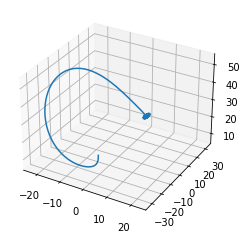

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from IPython import display 

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.set_xlim((-25,25))
ax.set_ylim((-35,35))
ax.set_zlim((5,55))

ax.plot(x_t[:,0],x_t[:,1],x_t[:,2])

Die Trajektorie ist jetzt zu animieren! Dafür erstellen wir erst einmal wieder die Axen

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')

ax.set_xlim((-25,25))
ax.set_ylim((-35,35))
ax.set_zlim((5,55))
plt.close()

Wir möchten, dass ein Punkt an der Trajektorie entlang läuft und dass die zurückgelegte Strecke gezeichnet wird. Erstellen wir diesen Punkt und eine Linie für die Strecke:

In [7]:
line = ax.plot([],[],[], '-', c='C1')[0] #Verbindet alle Datenpunkte in einer Linie
point = ax.plot([],[],[],'o', c='C1')[0] #Zeichnet an den Datenpunkten einen Kreis

Am besten stellen wir auch noch einen guten Blickwinkel ein: 

In [8]:
ax.view_init(30,0) #(phi,theta) 30 Grad Höhenwinkel

Nun ist die Animationsfunktion dran. Unsere Zeitvariable heißt hier <code>i</code>. Die Linie soll bis zur i-ten Stelle der Trajektorie gezeichnet werden. Der Punkt wird dann an das Ende dieser Strecke gesetzt. Abschließend wird noch der horizontale Blickwinkel größer, was für eine coole Drehung sorgt.

In [9]:
def animieren1(i):
    i = 2*i #Animation in zweier Schritten, einfach nur weil dies für schönere Ergebnisse sorgt
    
    x,y,z = x_t[:i].T
    line.set_data(x,y)
    line.set_3d_properties(z)
    
    point.set_data(x[-1:],y[-1:])
    point.set_3d_properties(z[-1:])
    
    ax.view_init(30,0.3*i) #Stellt die Blickrichtung mit zwei Winkeln ein. Das Erscheinung dreht sich mit der Zeit.

Nun muss das Video nur gerendert und angezeigt werden!:

In [12]:
anim = FuncAnimation(fig,animieren1, frames = 500, interval = 30)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Jetzt möchten wir natürlich wissen, wie die Trajektorien für leicht-verschiedene Startwerte aussehen. Wir werden jetzt die Kurven von vielen Startwerten gleichzeitig plotten.

Dafür erst einmal wieder die Axen:

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.axis('off')

ax.set_xlim((-25,25))
ax.set_ylim((-35,35))
ax.set_zlim((5,55))
plt.close()

Wir brauchen nun eine Liste von zufälligen Startwerten. Diese erstellen wir so:

In [11]:
N = 30 #Anzahl der Trajektorien

x0 = -15 + 15*2*np.random.random((N,3))

Jetzt sind in <code>x0</code> 30 zufällige Anfangspunkte mit Koordinaten zwischen -15 und 15 gespeichert.

Als nächstes müssen für alle Startpunkte die Trajektorien berechnet werden:

In [12]:
t = np.linspace(0,5, 1000)
x_t = np.asarray([odeint(lorentz_ableitung, x0i, t) for x0i in x0])

Dann erstellen wir eine Liste für die verschiedenen Punkte und Linien, die gezeichnet werden sollen (Am besten auch noch mit verschiedenen Farben!) und setzen den Blickwinkel richtig:

In [13]:
lines = [ax.plot([],[],[], '-', c='C{}'.format(n))[0] for n in range(N)]
points = [ax.plot([],[],[],'o', c='C{}'.format(n))[0] for n in range(N)]

ax.view_init(30,0)

Diesen Teil haben wir vorher nicht gemacht. Wenn sich mehrere Sachen in Matplotlib-Animationen bewegen, dann kommt es zu großen Problemen in der Performance. Aus diesem Grund verwenden wir jetzt das "Blitting"-Feature von Matplotlib. Dafür werden wir jetzt eine Init-Funktion erstellen, die dann eine Liste von den Objekten ausgibt, die sich in der Animationen ändern: 

In [14]:
def init():
    for line, pt in zip(lines, points):
        line.set_data([],[])
        line.set_3d_properties([])
    
        point.set_data([],[])
        point.set_3d_properties([])
    
    return lines + points

Jetzt ist es Zeit die Animationsfunktion zu erstellen. In der zeichnen wir alle Punkte und Linien in einer Schleife und drehen die Kamera bisschen herum. Dieses Mal müssen am Ende wieder die sich verändernden Objekte abgeben.

In [15]:
def animieren1(i):
    
    for line, point, xi in zip(lines,points,x_t):
        x,y,z = xi[:i].T
        line.set_data(x,y)
        line.set_3d_properties(z)
    
        point.set_data(x[-1:],y[-1:])
        point.set_3d_properties(z[-1:])
    
    ax.view_init(30,0.3*i)
    
    return lines + points

So jetzt sind wir fast fertig. Wenn wir jetzt <code>FuncAnimation</code> aufrufen, müssen wir noch angeben, dass Blitting verwendet werden soll und was unsere Init-Funktion ist:

In [18]:
anim = FuncAnimation(fig,animieren1,init_func = init, frames = 1000, interval = 30, blit=True)

AttributeError: 'list' object has no attribute 'shape'

Lasst uns endlich das schöne Resultat sehen:

In [17]:
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Siehe da, leicht verschiedene Anfangswerte führen im Phasenraum zu komplett verschiedenen Trajektorien, die sich nicht schneiden. Das einzige Attraktive in diesem System, ist diese schöne Schmetterlingsgestalt, die die Trajektorien aufspannen. Das ist der Lorenz-Attraktor.

#### Lorentz-Attraktor mit dem Einschrittverfahren

Wie könnte man diese Simulation auch ohne Solver erstellen? Kleine Warnung: Die folgende Methode wird viel ungenauer und auch leistungshungriger als die Methode mit <code>odeint</code>. Also sollte man so gut es gehend diese Methode vermeiden (zumindest in Python).

Die Geschwindigkeit an einem Punkt ist doch gegeben durch die Funktion:

In [18]:
def lorentz_ableitung(xyz, sigma= 10., beta = 8./3, rho = 28.0): 
    
    x, y, z = xyz
    
    xpunkt = sigma*(y-x)
    ypunkt = x*(rho - z)- y
    zpunkt = x*y - beta*z
    
    return [xpunkt,ypunkt,zpunkt] #Gibt die Zeitableitung des angebenen Vektor ab

Der Plan ist jetzt einfach in der Animationsfunktion die Punkte jedes Mal einen kleinen Schritt mit dieser Geschwindigkeit zu bewegen. Dafür erstellen wir zunächst einen weiteren Punkt, der die momentanen Position angeben wird, und zusätzlich noch eine Liste, in der wie die zurückgelassene Strecke speichern:

In [19]:
x_mom = x0 #Am Anfang ist die momentane Position am Startpunkt
s = [x_mom]

Eine Variable für die Schrittgröße wäre auch nützlich:

In [20]:
ds = 0.01

Nun kommen wir zur viel komplizierteren Animationsfunktion. Hier berechnen wir zunächst die Geschwindigkeit der momentanen Position, dann setze wir die momentane Position auf die um einen Schritt verschobene Position und schließlich fügen wir die neue momentane Position zu Strecke hinzu. Dies wiederholen wir für jede einzelne Trajektorie. 

In [21]:
def animieren1(i):
    
    for n,linenpoint in enumerate(zip(lines,points)):
        line, point = linenpoint
        
        #Berechnung der Geschwindigkeit:
        xpunkt = lorentz_ableitung(x_mom[n])
        
        x,y,z = x_mom[n]
        #Verschiebe die momentane Position um einen kleinen Schritt
        x_mom[n] = np.array([x + ds*xpunkt[0], y + ds*xpunkt[1], z + ds*xpunkt[2]])
        
        #Füge diese neue Position der Strecke hinzu:
        s.append(x_mom[n])
        
        
        point.set_data(x_mom[n][0],x_mom[n][1])
        point.set_3d_properties(x_mom[n][2])
        
        #Strecken erstellen (index Error)
        
        #line.set_data(s[:][0],s[:][1])
        #line.set_3d_properties(s[:][2])
    
    ax.view_init(30,0.3*i)
    
    return lines + points

Es felt nur noch das Rendern:

In [22]:
anim = FuncAnimation(fig,animieren1,init_func = init, frames = 1000, interval = 30, blit=True)

In [23]:
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

## Letzte Anmerkungen

Jetzt ist die erste Simulation fertig programmiert. Simulationen in der Physik sehen immer so aus. Dabei ist das Animieren jedoch teilweise nicht der schwere Teil von diesen Simulationen sondern das Herausfinden der Differentialgleichungen bzw. der Geschwindigkeiten. Die Geschwindigkeiten lassen sich manchmal leicht selbst bestimmen (beispielsweise muss man bei Planetenbewegungen nur die ganzen Kräfte addieren und kommt somit auf die Geschwindigkeiten) jedoch ist es oft der Fall, dass beispielsweise Nebenbedingungen und die Ausdehnungen von Objekten diese Arbeit erschwert. Hierfür wird uns am nächsten Workshop-Tag <code>sympy.physics.mechanics</code> besonders helfen. Mit diesem Modul können wir Systeme leicht physikalisch beschreiben und dann werden uns die richtigen DGL sofort ausgespuckt.

# Flächenplots

Seit letztes Mal haben wir angefangen mit 3D-Plots in Matplotlib zu arbeiten. In drei Dimensionen gibt es zusätzlich noch die Möglichkeit Flächen zu zeichnen. Matplotlib bietet hierfür verschiedene Arten von Flächenplots, wie zum Beispiel:

#### Wireframes

Mit Wireframes kann man rasterartig Flächen darstellen. Diese sehen dann so aus:

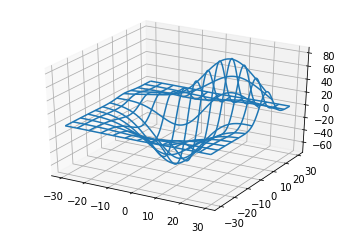

In [24]:
from mpl_toolkits.mplot3d.axes3d import get_test_data

fig = plt.figure()
ax = fig.add_subplot(111,projection ='3d')

#Daten zum Testen der Flächenplots
X,Y,Z = get_test_data(0.05)

#Drahtmodell
#rstride, cstride sind Abstände der Linien
ax.plot_wireframe(X,Y,Z,rstride=10, cstride=10)


plt.show()

Beim Erstellen dieser Flächen müssen in <code>plot_wireframe</code> neben den Daten die Parameter <code>rstride</code> und <code>cstride</code> angegeben werden. Dabei gibt <code>cstride</code> den Abstand der Spaltenlinien an und <code>rstride</code> gibt den Abstand der Reihenlinien an.

#### Ausgefüllte Flächen

Auch undurchsichtige Flächen können gezeichnet werden. Dabei kann man zusätzlich noch das Colormap-Feature von Matplotlib verwenden um die Datengrößen auf der Fläche auch farbig zu kennzeichnen. Zum Erstellen des Plots wird die Methode <code>plot_surface</code> aufgerufen und für den Parameter <code>cmap</code> wird <code>matplotlib.cm.coolwarm</code> angegeben. Abschließend wird noch ein passender Farbbalken mit der Methode <code>fig.colorbar</code> erstellt.

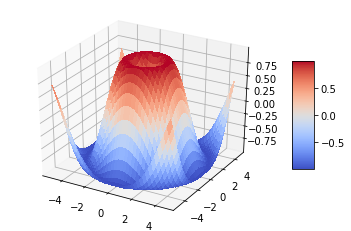

In [25]:
#Farbtöne:
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

#Daten
x = np.arange(-5,5,0.25)
y = np.arange(-5,5,0.25)
x, y = np.meshgrid(x,y)
r = np.sqrt(x**2+y**2)
z = np.sin(r)

#Plot
surf = ax.plot_surface(x,y,z, cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf,shrink= 0.5, aspect = 5)

plt.show()

#### Körper

Eingeschlossene Flächen zu zeichnen ist ein wenig schwieriger und benötigt bisschen mehr Mathematik. Hier erstellen wir eine Kugel. Dafür wird zunächst ein Mesh-Grid für die zwei Winkel erstellt ($u$ geht von $0$ bis $2\pi$ und $v$ geht von $0$ bis $\pi$). Nun kann die Oberfläche anhand der Kugelkoordinaten gezeichnet werden:

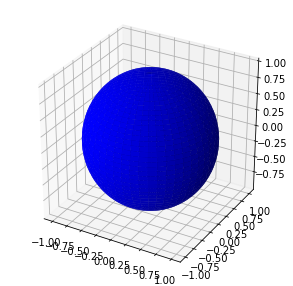

In [26]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection='3d')

#Daten
u, v = np.mgrid[0:2*np.pi:0.01, 0:np.pi:0.01]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
#ax.plot_wireframe(x, y, z, color="r",cstride=40, rstride=40)

ax.plot_surface(x,y,z, color='b')

plt.show()

### Flächenplot-Animationen

Animationen mit Flächen sieht ein kleines bisschen anders als wie wir es gewohnt sind. Wir möchten jetzt eine einfache Welle animieren. Zeichnen wir dieses zunächst einmal ohne eine Animation:

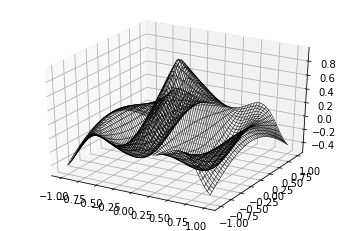

In [27]:
#Wellenfunktion für die Z-Achse. 
def generate(x, y, phi):
    """Erstellt Daten für Z"""
    R = 1 - np.sqrt(x**2 + y**2)
    return np.cos(2*np.pi * x + phi)*R

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')

x = np.linspace(-1,1,50)
y = np.linspace(-1,1,50)
x, y = np.meshgrid(x,y)

z = generate(x,y, 0)

ax.plot_wireframe(x,y,z,color= 'k', rstride=1, cstride=1, linewidth=0.5)
plt.show()

Wenn wir nun diese Welle animieren wollen, dann stoßen wir auf ein Problem: Wir haben nicht mehr die Möglichkeit über <code>line.set_data</code> die Plotdaten zu ändern. Im folgendem Code plotten wir jedes Mal in der Animationensfunktion die Fläche. Dadurch überlagern sich jedoch alle Flächen und es sieht nicht mehr schön aus:

In [28]:

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.set_zlim((-1,1))
x = np.linspace(-1,1,50)
y = np.linspace(-1,1,50)
x, y = np.meshgrid(x,y)

z = generate(x,y, 0)

phis = np.linspace(0,180./np.pi,100)#Liste von Phasen

def animieren(frame):
    z = generate(x,y,phis[frame]) #Die Phase ändert sich mit der Zeit
    ax.plot_wireframe(x,y,z, rstride=1,cstride=1, color='k',linewidth=0.5)

anim = FuncAnimation(fig,animieren, frames = 10, interval = 100)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Um dieses Problem zu lösen, müssen wir jedes Mal bevor wir die nächste Fläche plotten die Alte löschen.Das Löschen geht zum Glück ganz leicht mit der Methode <code>ax.collection.remove</code>:

In [29]:

fig = plt.figure()

ax = fig.add_subplot(111,projection = '3d')
ax.axis("off")
ax.set_zlim((-1,1))

x = np.linspace(-1,1,50)
y = np.linspace(-1,1,50)
x, y = np.meshgrid(x,y)

z = generate(x,y, 0)

phis = np.linspace(0,180./np.pi,100)

wframe = None
def animieren(frame):
    global wframe 
    #Wenn ein wframe schon existiert, lösche es bevor erneut gezeichnet wird
    if wframe:
        ax.collections.remove(wframe)
        
    
    z = generate(x,y,phis[frame])
    wframe = ax.plot_wireframe(x,y,z, rstride=1,cstride=1, color='k',linewidth=0.5)

anim = FuncAnimation(fig,animieren, frames = 10, interval = 100)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Hier nochmal die selbe Animation mit einer Kamera, die sich bewegt:

In [30]:
def animieren(frame):
    global wframe 
    #Wenn ein wframe schon existiert, lösche es bevor erneut gezeichnet wird
    if wframe:
        ax.collections.remove(wframe)
        
    
    z = generate(x,y,phis[frame])
    wframe = ax.plot_wireframe(x,y,z, rstride=1,cstride=1, color='k',linewidth=0.5)
    ax.view_init(30,4.5*frame+45)
    

anim = FuncAnimation(fig,animieren, frames = 80, interval = 100)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

## Aufgaben